<a href="https://colab.research.google.com/github/Esandu-Meth-Obadaarachchi/Image_classification_model_trial/blob/main/image_classification_model_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
     "/content/drive/MyDrive/dsgp dataset/private project dataset",
    seed=123,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)
class_names = dataset.class_names
class_names

Found 883 files belonging to 8 classes.


['Anthracnose',
 'algal leaf',
 'bird eye spot',
 'brown blight',
 'gray light',
 'healthy',
 'red leaf spot',
 'white spot']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[5 6 1 5 7 4 3 4 7 6 1 6 7 5 3 2 6 5 5 2 2 4 2 2 7 7 4 6 1 0 2 1]


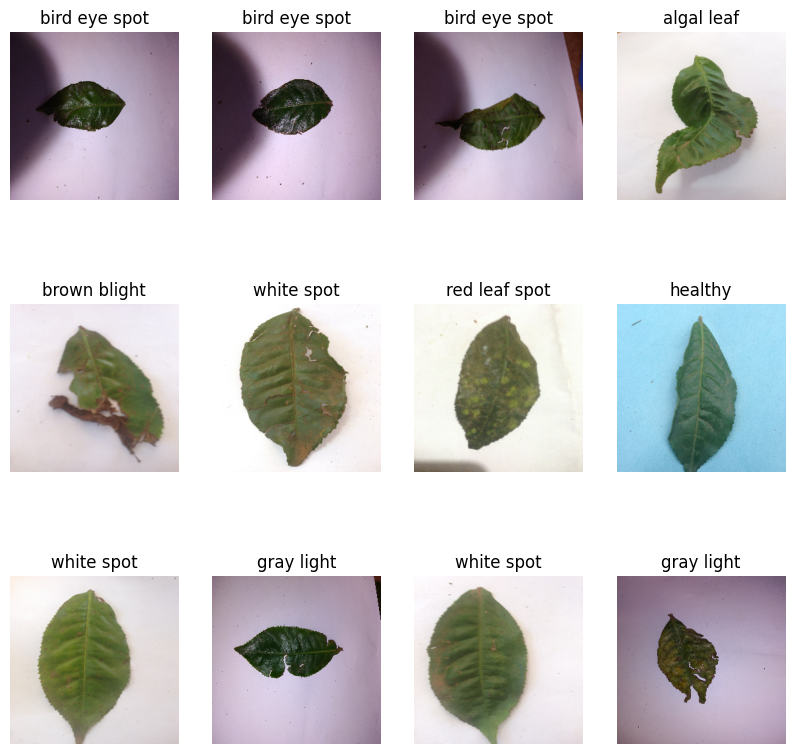

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [24]:
def random_hue(image, max_delta=0.2):
    return tf.image.adjust_hue(image, tf.random.uniform([], -max_delta, max_delta))

def random_brightness(image, max_delta=0.2):
    return tf.image.adjust_brightness(image, tf.random.uniform([], 1-max_delta, 1+max_delta))

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.Lambda(lambda x: random_hue(x)),
    layers.Lambda(lambda x: random_brightness(x)),
    layers.experimental.preprocessing.RandomContrast(0.2),
    layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
])


In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 8
#added more layers and made it more complex
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, kernel_size=(3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),  # Increased neurons

    layers.Dropout(0.5),  # Adding dropout for regularization
    layers.Dense(n_classes, activation='softmax'),
])



model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 128)       3584      
                                                                 
 batch_normalization (Batch  (32, 254, 254, 128)       512       
 Normalization)                                                  
                                                                 
 max_pooling2d_6 (MaxPoolin  (32, 127, 127, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 256)       295168    
                                                                 
 batch_normalization_1 (Bat  (32, 125, 125, 256)      

In [27]:
model.compile(
     optimizer="adamax",
     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
22/22 [==============================] - 892s 40s/step - loss: 2.3905 - accuracy: 0.3792 - val_loss: 2.6282 - val_accuracy: 0.1719
Epoch 2/50
22/22 [==============================] - 881s 41s/step - loss: 1.7109 - accuracy: 0.4732 - val_loss: 3.7817 - val_accuracy: 0.0938
Epoch 3/50
 1/22 [>.............................] - ETA: 13:27 - loss: 1.3305 - accuracy: 0.5000

In [17]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 34s 895ms/step - loss: 1.1211 - accuracy: 0.5312


In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

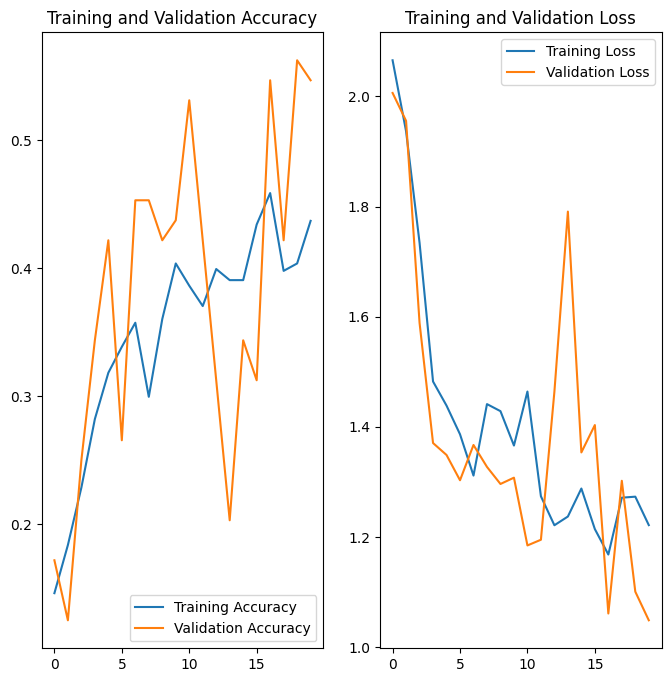

In [19]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(EPOCHS, acc, label='Training Accuracy')
plt.plot(EPOCHS, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(EPOCHS, loss, label='Training Loss')
plt.plot(EPOCHS, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: red leaf spot
1/1 [==============================] - 1s 1s/step
predicted label: red leaf spot


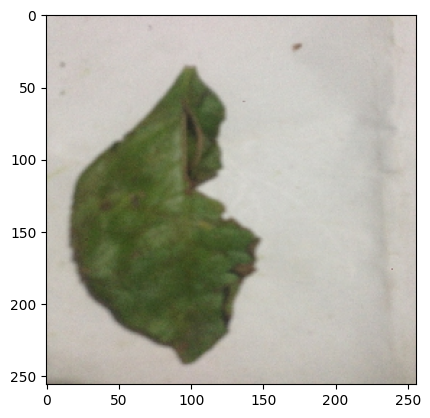

In [20]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [21]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


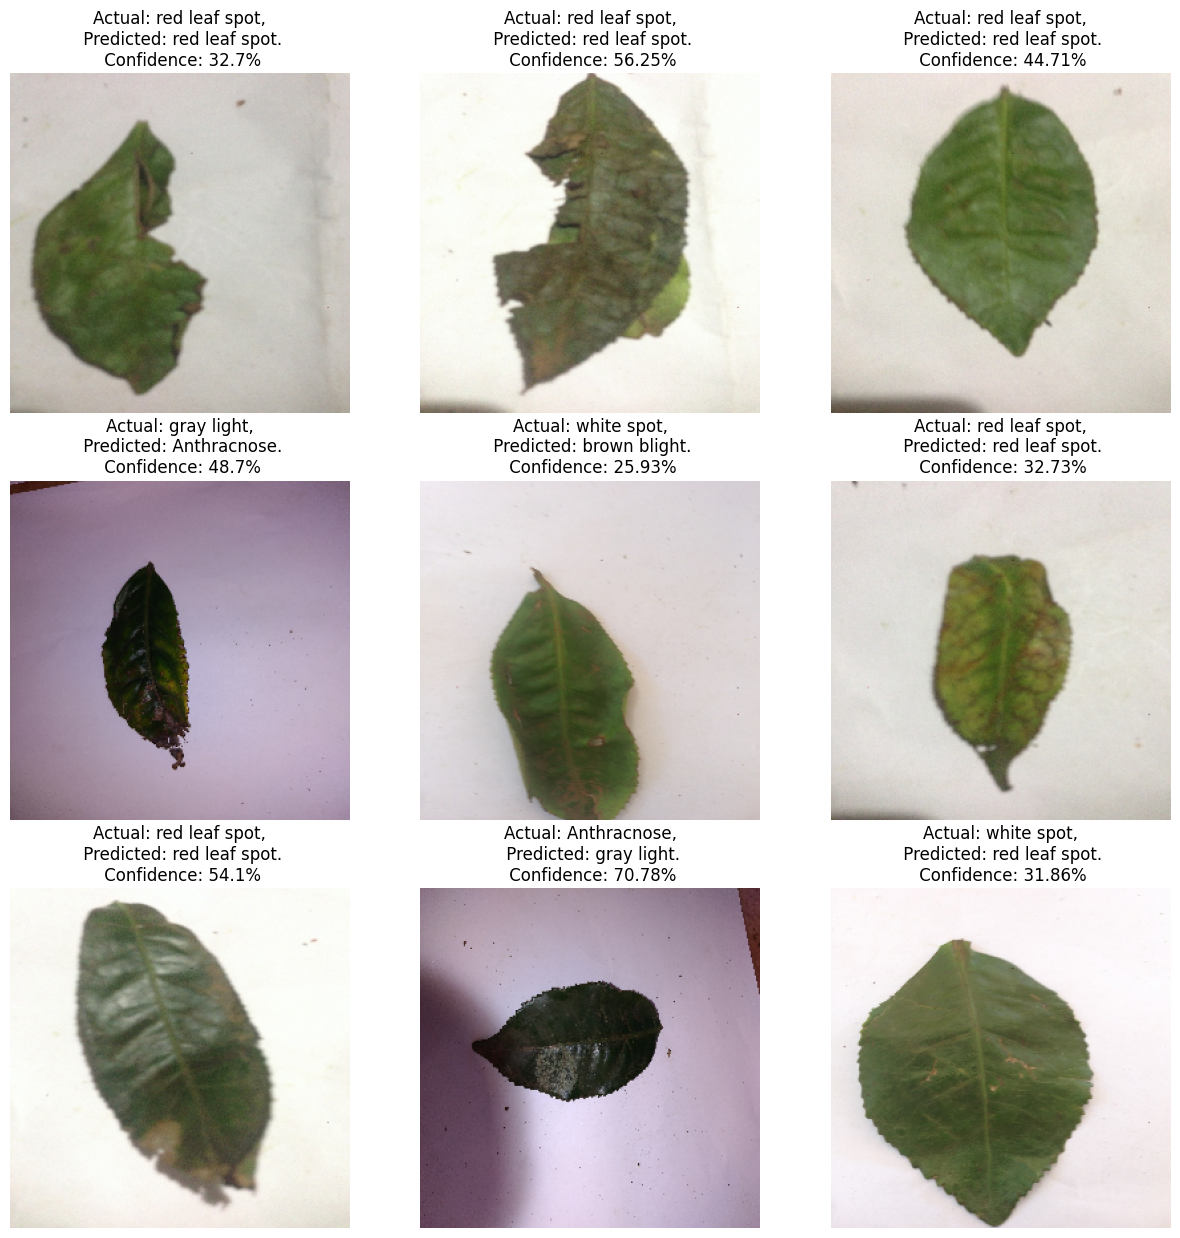

In [22]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [23]:
import os
from keras.models import load_model

# Replace 'model' with the name of your model
model_name = 'trial_adam_accuracy'

# Path to your Google Drive
drive_path = "/content/drive/MyDrive/colab_NoteBooks"

# Full path for saving the model
save_path = os.path.join(drive_path, model_name)

# Save the model
model.save(save_path)